In [1]:
!pip install patchify

In [2]:
!pip install wandb

In [2]:
import rasterio
import os
import shutil
import numpy as np
from rasterio.plot import show
from matplotlib import pyplot as plt
from patchify import patchify
import tifffile as tiff
import tensorflow as tf

In [3]:
img1 = rasterio.open('../input/isro-satellite-data/k3_20191229071905_40634_06371168_l1g_nrg.tif')
img2 = rasterio.open('../input/isro-satellite-data/k3_20191229071905_40634_06371168_l1g_p.tif')

In [4]:
full_img_1 = img1.read()
full_img_2 = img2.read()

In [5]:
new_img2 = ((full_img_2 - full_img_2.min()) * (1/(full_img_2.max() - full_img_2.min()) * 255))
new_img2 = new_img2.reshape(new_img2.shape[1],new_img2.shape[2])

In [6]:
new_img1_b1 = ((full_img_1[0] - full_img_1[0].min()) * (1/(full_img_1[0].max() - full_img_1[0].min()) * 255))
new_img1_b2 = ((full_img_1[1] - full_img_1[1].min()) * (1/(full_img_1[1].max() - full_img_1[1].min()) * 255))
new_img1_b3 = ((full_img_1[2] - full_img_1[2].min()) * (1/(full_img_1[2].max() - full_img_1[2].min()) * 255))
new_img1_3L = np.stack([new_img1_b1/3,new_img1_b2/3,new_img1_b2/3],axis = 2)
new_img1 = np.mean(new_img1_3L, axis=2)

In [7]:
if not os.path.isdir('patches/'):
    os.mkdir('patches/')
    
else:
    shutil.rmtree('patches/')
    os.mkdir('patches/')
    
if not os.path.isdir('patches/lr_image/'):
    os.mkdir('patches/lr_image/')


large_image = new_img2

patches_img = patchify(large_image, (512, 512), step=512)

for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
        single_patch_img = tf.image.resize(patches_img[i,j,:,:].reshape(512,512,1),[256,256],method= 'area')
        tiff.imwrite('patches/lr_image/' + 'image_' + '0' + '_' + str(i)+str(j)+ ".tif", tf.reshape( single_patch_img, [256,256]).numpy()) 

2022-12-30 05:35:39.409313: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-30 05:35:39.506906: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-30 05:35:39.507647: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-30 05:35:39.510135: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [8]:
if not os.path.isdir('patches/'):
    os.mkdir('patches/')
    
    
if not os.path.isdir('patches/lr_image_original/'):
    os.mkdir('patches/lr_image_original/')
    

large_image = new_img1

patches_img = patchify(large_image, (128, 128), step=128) 

for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):

        single_patch_img = patches_img[i,j,:,:]
        tiff.imwrite('patches/lr_image_original/' + 'image_' +  '0' + '_' + str(i)+str(j)+ ".tif", single_patch_img)

In [18]:
if not os.path.isdir('patches/hr_image/'):
    os.mkdir('patches/hr_image/')



large_image = new_img2

patches_img = patchify(large_image, (512, 512), step=512)

for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):

        single_patch_img = patches_img[i,j,:,:]
        tiff.imwrite('patches/hr_image/' + 'image_' + '0' + '_' + str(i)+str(j)+ ".tif", single_patch_img) 

In [12]:
import gc
del(img1)
del(img2)
del(full_img_1)
del(full_img_2)
del(new_img1_3L)
del(new_img1_b1)
del(new_img1_b2)
del(new_img1_b3)
del(new_img1)
del(new_img2)
gc.collect()

121

In [15]:
import os
import cv2
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

import tensorflow as tf
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, PReLU,BatchNormalization, Flatten,MaxPooling2D, Lambda
from tensorflow.keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm
from keras.models import load_model
from numpy.random import randint

In [ ]:
!wandb login --relogin

Error in callback <function _WandbInit._resume_backend at 0x7fc6184cdc20> (for pre_run_cell):


Exception: The wandb backend process has shutdown

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

In [3]:
import wandb
wandb.init(entity="isro_project", project = "skip_connection_models")

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [19]:
lr_list = os.listdir('patches/lr_image_original/')
hr_list = os.listdir('patches/hr_image/')
lr_list.sort()
hr_list.sort()

def log_transformed(img):
    c = 255/(np.log(1 + np.max(img)))
    log_transformed = c * np.log(1 + img)

    # Specify the data type.
    log_transformed = np.array(log_transformed, dtype = np.uint8)
    return log_transformed

lr_images = []
for img in lr_list:
    img_lr =rasterio.open("patches/lr_image_original/" + img)
    img_lr = img_lr.read()
    img_lr = img_lr.reshape((img_lr.shape[1],img_lr.shape[2],img_lr.shape[0]))
    lr_images.append(log_transformed(img_lr))   

   
hr_images = []
for img in hr_list:
    img_hr =rasterio.open("patches/hr_image/" + img)
    img_hr = img_hr.read()
    img_hr = img_hr.reshape((img_hr.shape[1],img_hr.shape[2],img_hr.shape[0]))
    hr_images.append(log_transformed(img_hr))   

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

/opt/conda/lib/python3.7/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [11]:
lr_list = os.listdir('patches/lr_image/')
hr_list = os.listdir('patches/hr_image/')
lr_list.sort()
hr_list.sort()

def log_transformed(img):
    c = 255/(np.log(1 + np.max(img)))
    log_transformed = c * np.log(1 + img)

    # Specify the data type.
    log_transformed = np.array(log_transformed, dtype = np.uint8)
    return log_transformed

lr_images = []
for img in lr_list:
    img_lr =rasterio.open("patches/lr_image/" + img)
    img_lr = img_lr.read()
    img_lr = img_lr.reshape((img_lr.shape[1],img_lr.shape[2],img_lr.shape[0]))
    lr_images.append(log_transformed(img_lr))   

   
hr_images = []
for img in hr_list:
    img_hr =rasterio.open("patches/hr_image/" + img)
    img_hr = img_hr.read()
    img_hr = img_hr.reshape((img_hr.shape[1],img_hr.shape[2],img_hr.shape[0]))
    hr_images.append(log_transformed(img_hr))   

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

/opt/conda/lib/python3.7/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [10]:
#Define blocks to build the generator
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)
    return Model(inputs=gen_ip, outputs=op)

#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.5 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model


#Descriminartor, as described in the original paper
def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)



from tensorflow.keras.applications.vgg19 import VGG19

def build_incep(hr_shape):
    
    incep = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=incep.inputs, outputs=incep.layers[6].output)

def gray_to_rgb(images):
    return  tf.image.grayscale_to_rgb(images)

def rgb_to_gray(images):
    return  tf.image.rgb_to_grayscale(images)



#Combined model
def create_comb(gen_model, disc_model, incep, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    #lambda_layer = tf.keras.layers.Lambda(rgb_to_gray, name="lambda_layer")(gen_img)
    lambda_layer = tf.keras.layers.Lambda(gray_to_rgb, name="lambda_layer")(gen_img)
    gen_features = incep(lambda_layer)
    
    #gray_fearures = tf.keras.layers.Lambda(rgb_to_gray, name="lambda_layer")(gen_features)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 

In [11]:
from keras.layers import ZeroPadding2D , PReLU , Input,MaxPool2D,Conv2DTranspose ,Conv2D , Add, Dense , AveragePooling2D , UpSampling2D , Reshape , Flatten , Subtract , Concatenate , Lambda
def UpBlocks(L,filters=12 , channel = 64):
    # x = ZeroPadding2D(padding=(2,2))(x)
    L = Conv2D(filters=channel , kernel_size = 1 , strides=1,kernel_initializer='glorot_uniform' ,padding='valid' )(L)
    L = PReLU(alpha_initializer='zero' , shared_axes=[1, 2 ])(L)

    Ht = Conv2DTranspose(filters=channel , kernel_size=filters  , strides=(8,8) ,  kernel_initializer='glorot_uniform' ,padding='same')(L)
    Ht = PReLU(alpha_initializer='zero' , shared_axes=[1, 2 ])(Ht)

    Lt = Conv2D(filters= channel , kernel_size=filters, strides=(8 , 8) , kernel_initializer='glorot_uniform' , padding='same')(Ht)
    Lt = PReLU(alpha_initializer='zero' , shared_axes=[1, 2 ])(Lt)

    et = Subtract()([Lt ,L])

    H1t = Conv2DTranspose(filters=channel , kernel_size=filters  , strides=(8,8) ,  kernel_initializer='glorot_uniform' ,padding='same')(et)
    H1t = PReLU(alpha_initializer='zero' , shared_axes=[1, 2 ])(H1t)
    om = Add()([Ht,H1t])

    return om

def DownBlocks(H , filters=12 , channel = 64):

    H = Conv2D(filters=channel , kernel_size = 1 , strides=1,kernel_initializer='glorot_uniform' ,padding='same' )(H)
    H = PReLU(alpha_initializer='zero' , shared_axes=[1, 2 ])(H)

    Lt = Conv2D(filters= channel , kernel_size=filters, strides=(8 , 8) , kernel_initializer='glorot_uniform' , padding='same')(H)
    Lt = PReLU(alpha_initializer='zero' , shared_axes=[1, 2 ])(Lt)

    Ht = Conv2DTranspose(filters=channel , kernel_size=filters  , strides=(8,8) ,  kernel_initializer='glorot_uniform' ,padding='same')(Lt)
    Ht = PReLU(alpha_initializer='zero' , shared_axes=[1, 2 ])(Ht)

    et = Subtract()([Ht,H])

    L1t = Conv2D(filters= channel , kernel_size=filters , strides=(8 , 8) , kernel_initializer='glorot_uniform' , padding='same')(et)
    L1t = PReLU(alpha_initializer='zero' , shared_axes=[1, 2 ])(L1t)

    om = Add()([Lt , L1t])

    return om

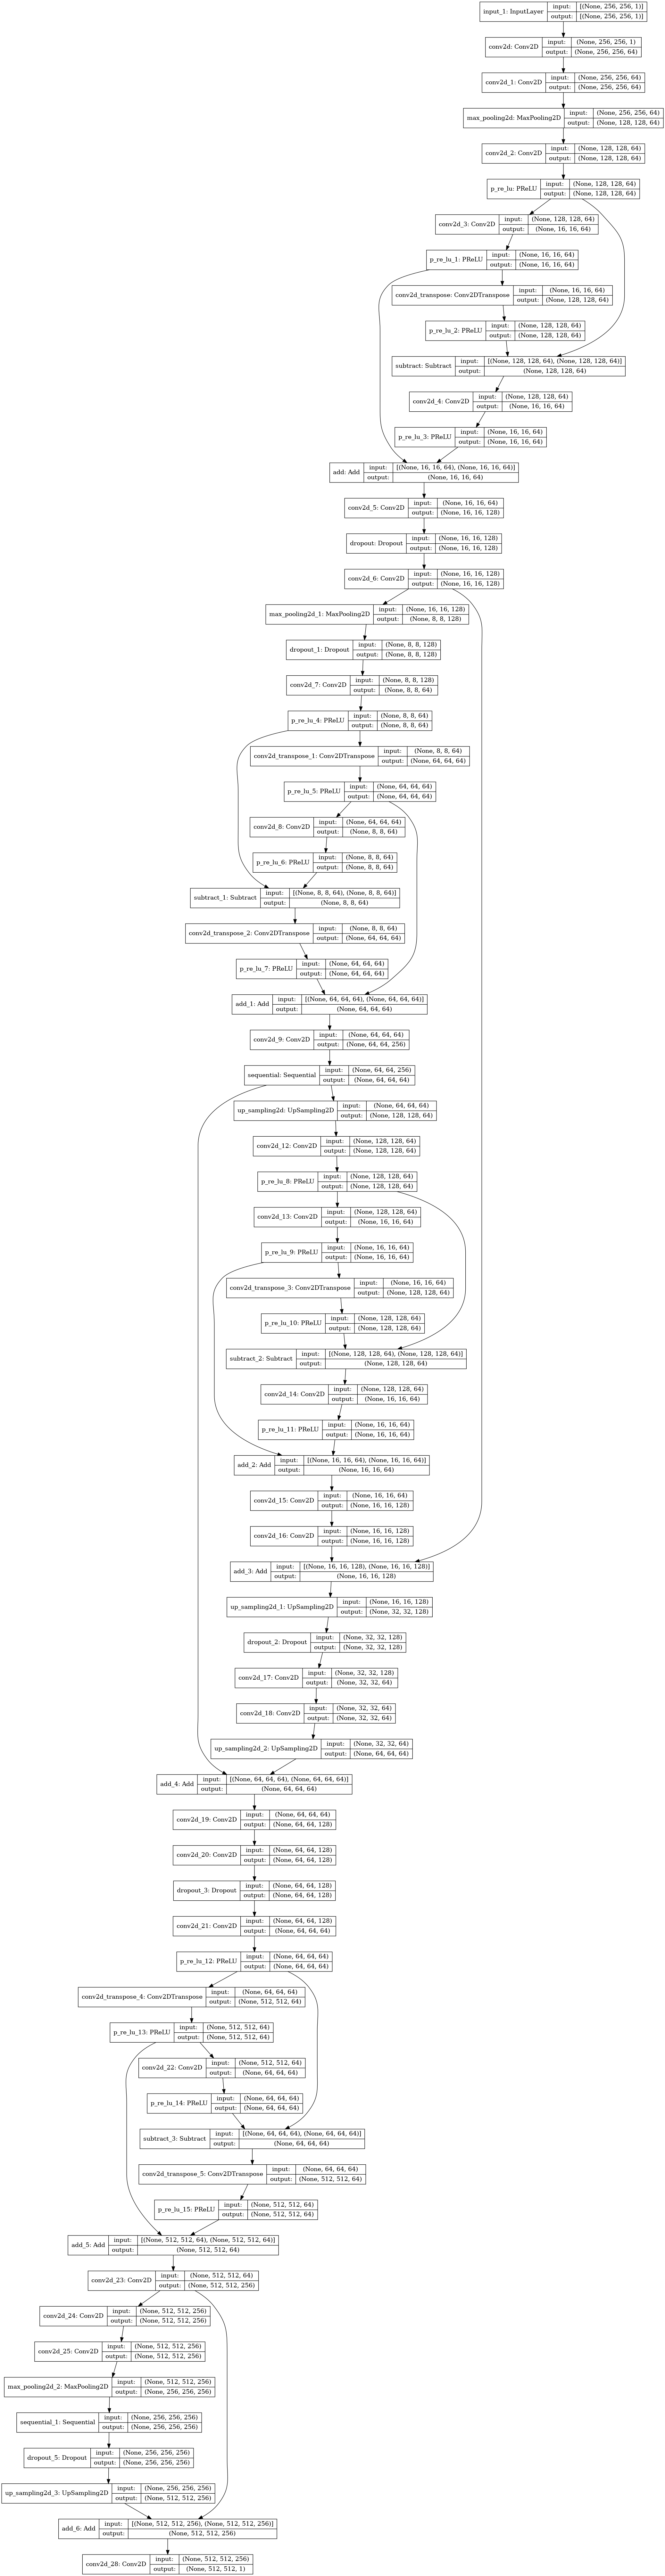

In [12]:
import os 
import re 
from scipy import ndimage, misc 
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import img_to_array


from skimage.transform import resize, rescale
import matplotlib.pyplot as plt
import numpy as np
np. random. seed(0)
import cv2 as cv2

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense ,Conv2D,MaxPooling2D ,Dropout
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
import tensorflow as tf

def wt_to_conv64(arr):
    return tf.tile(arr, [1,1,1,16])
def wt_to_conv128(arr):
    return tf.tile(arr, [1,1,1,32])

def residual_block_gen(ch=64,k_s=3,st=1):
    model=tf.keras.Sequential([
    tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),])
    return model

input_img=Input(shape=(256,256,1))
l1=Conv2D (64,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(input_img)
l2=Conv2D (64,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l1)
l3=MaxPooling2D(padding='same')(l2)

l3 = DownBlocks(l3)

l5=Conv2D (128,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l3)
l5 = Dropout(0.50)(l5)
l6=Conv2D (128,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l5)
l7=MaxPooling2D(padding='same')(l6)
l7 = Dropout(0.50)(l7)

l7 = UpBlocks(l7)

l8=Conv2D (256,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l7)
l8_0=residual_block_gen()(l8)
l8_1=UpSampling2D()(l8_0)

l8_2 = DownBlocks(l8_1)


l9=Conv2D (128,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l8_2)
l10=Conv2D (128,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l9)
l11=add([l10,l6])
l12=UpSampling2D()(l11)
l12 = Dropout(0.50)(l12)
l13=Conv2D (64,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l12)
l15=Conv2D (64,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l13)

#l15=add([l14,l2])

l16=UpSampling2D()(l15)

l16=add([l16,l8_0])

l17 = Conv2D(128,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l16)
l18 = Conv2D(128,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l17)
l18 = Dropout(0.50)(l18)
#l19=UpSampling2D()(l18)

l18 = UpBlocks(l18)

l20 = Conv2D(256,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l18)
l21 = Conv2D(256,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l20)
l22 = Conv2D(256,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l21)
l23 = Dropout(0.50)(l22)
l23=MaxPooling2D(padding='same')(l22)
l24 = residual_block_gen(ch=256)(l23)
l24 = Dropout(0.50)(l24)
l25=UpSampling2D()(l24)
l26=add([l25,l20])


decoder=Conv2D (1,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l26)

#out= tf.keras.filters
autoencoder_residual=Model(input_img,decoder)
plot_model(autoencoder_residual, to_file ='encoder.png',show_shapes=True)

In [13]:
def build_model_and_log(config,model,model_name):
    config = wandb.config
    model_artifact = wandb.Artifact(
        "generator", type="model",
        description="Deep Back-Projection network with skip connections",
        metadata=dict(config))

    model.save(model_name)
    # ➕ another way to add a file to an Artifact
    model_artifact.add_file(model_name)

    wandb.save(model_name)

    wandb.log_artifact(model_artifact)

model_config = {"No_of_dropput": [5],
                "UpBlocks": [2],
                "DownBlocks": [2],
                "ResBlock": [2],
                "SkipConn": [3],
                "activation": "ReLU",
                "dropout": 0.5,
                "SR": '2x'}

#build_model_and_log(model_config,autoencoder_residual,"generator.h5")

In [16]:
#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, 
                                                      test_size=0.33, random_state=42)



hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape,batch_size = 1)
hr_ip = Input(shape=hr_shape,batch_size = 1)

generator = autoencoder_residual#load_model('/kaggle/input/skip-conn-37epoch/gen_e_37.h5', compile=True)
generator.summary()

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

incep = build_incep((512,512,3))
print(incep.summary())
incep.trainable = False

gan_model = create_comb(generator, discriminator, incep, lr_ip, hr_ip)

# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

NameError: name 'lr_images' is not defined

In [29]:
#Create a list of images for LR and HR in batches from which a batch of images
#would be fetched during training. 
batch_size = 1  
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

In [30]:
train_log_dir = 'logs/train'
test_log_dir = 'logs/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [34]:
epochs = 50
#Enumerate training over epochs
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    def gray_to_rgb(images):
        img = tf.convert_to_tensor(images, dtype=tf.int64) 
        return  tf.image.grayscale_to_rgb(img).numpy()

    def rgb_to_gray(images):
        img = tf.convert_to_tensor(images, dtype=tf.int64) 
        return  tf.image.rgb_to_grayscale(img).numpy()
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        #gen_imgs = rgb_to_gray(fake_imgs)
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = incep.predict(gray_to_rgb(hr_imgs))
        
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        with train_summary_writer.as_default():
            tf.summary.scalar('generator loss',g_loss , step=b)
            tf.summary.scalar('Discriminator Loss(False-False)', d_loss[0], step=b)
            tf.summary.scalar('Discriminator Loss(True-True)', d_loss[1], step=b)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    [X1, X2] = [lr_test, hr_test]
    # select random example
    ix = np.array([2])
    src_image, tar_image = X1[ix], X2[ix]
    
    gen_image = generator.predict(src_image)
    
    wandb.log({"g_loss": g_loss, "epoch": e+1,
           'Discriminator Loss(False-False)': d_loss[0],
           'Discriminator Loss(True-True)': d_loss[1],
           "outputs": wandb.Image(gen_image,caption = 'output_of_epoch_{}'.format(37+1) )})
    
    #Report the progress during training. 
    print("epoch:", 37+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 1 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        model_name = "gen_e_"+ str(37+1) +".h5"
        build_model_and_log(model_config,generator,model_name)
        

  0%|          | 0/882 [00:00<?, ?it/s]2022-12-24 16:08:19.391800: W tensorflow/core/common_runtime/bfc_allocator.cc:457] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.00GiB (rounded to 2147483648)requested by op gradient_tape/model_7/dense_4/MatMul_1
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-12-24 16:08:19.391885: I tensorflow/core/common_runtime/bfc_allocator.cc:1004] BFCAllocator dump for GPU_0_bfc
2022-12-24 16:08:19.391910: I tensorflow/core/common_runtime/bfc_allocator.cc:1011] Bin (256): 	Total Chunks: 208, Chunks in use: 207. 52.0KiB allocated for chunks. 51.8KiB in use in bin. 31.4KiB client-requested in use in bin.
2022-12-24 16:08:19.391923: I tensorflow/core/common_runtime/bfc_allocator.cc:1011] Bin (512): 	Total Chunks: 64, Chunks in use: 62. 33.0KiB allocated for chunks. 32.0KiB in use in bi

ResourceExhaustedError:  OOM when allocating tensor with shape[524288,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/model_7/dense_4/MatMul_1 (defined at tmp/ipykernel_17/3079839348.py:30) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_25530]

Function call stack:
train_function


In [28]:
[X1, X2] = [lr_test, hr_test]
# select random example
ix = np.array([2])
src_image, tar_image = X1[ix], X2[ix]

gen_image = generator.predict(src_image)
wandb.init()
wandb.log({
       "test_data": 4678})

In [ ]:
gen_loss = [115.20941616780634,113.976418678993,113.76942759684695,113.12779033427336,113.25671683958058,112.60468086039398,112.86494744986364,112.24326507412657,111.99943249349961, 111.85351464105031,111.61091884734138,111.30855091683178,111.20278746308654,110.8413352393239,110.74683088185836,110.53594053683638]
dis_loss = [[1.88655743, 0.18041383],[0.74163327, 0.12698413],[0.69359824, 0.49957483],[0.69324515, 0.41099773],[0.69332292, 0.36904762],[0.69328549, 0.38818027],[0.69328383, 0.06448413],[0.69329057, 0.26403061],[0.69325749, 0.22576531],[0.69325227, 0.13265306],[0.69325271, 0.22803288],[0.69324588, 0.21768707],[0.69325097, 0.20181406],[0.69324588, 0.22420635],[0.69326526, 0.29265873],[0.69338483, 0.41170635]]
gen_loss = np.array(gen_loss)
dis_loss = np.array(dis_loss)
epochs = np.array([i for i in range(1,17)])
plt.plot(epochs, gen_loss,marker = '.',label = 'Generator Loss')
plt.plot(epochs,dis_loss[:,0]*100,marker = '.',label = 'Discriminator Loss(False-False)')
plt.plot(epochs,dis_loss[:,1]*100,marker = '.',label = 'Discriminator Loss(True-True)')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Values')

In [ ]:
#Create a list of images for LR and HR in batches from which a batch of images
#would be fetched during training. 
batch_size = 1  
train_lr_batches = []
train_hr_batches = []
for it in range(int(lr_images.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_lr_batches.append(lr_images[start_idx:end_idx])

In [ ]:
#Test - perform super resolution using saved generator model
from keras.models import load_model
from numpy.random import randint

#generator = load_model('../input/ae-gan-2x/gen_e_30.h5', compile=False)#autoencoder_residual

def rgb_to_gray(images):
    return  tf.image.rgb_to_grayscale(images).numpy()

[X1, X2] = [lr_test, hr_test]
# select random example
ix = np.array([2])
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)

cv2.imwrite('SR_IMG_3.tif', gen_image.reshape(256,256,1))

cv2.imwrite('LR_IMG_3.tif', src_image.reshape(128,128,1))

cv2.imwrite('HR_IMG_3.tif', tar_image.reshape(256,256,1))

# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()

In [21]:
# import modules
import cv2
import numpy as np
import math
import sys
import time


# Interpolation kernel
def u(s, a):
	if (abs(s) >= 0) & (abs(s) <= 1):
		return (a+2)*(abs(s)**3)-(a+3)*(abs(s)**2)+1
	elif (abs(s) > 1) & (abs(s) <= 2):
		return a*(abs(s)**3)-(5*a)*(abs(s)**2)+(8*a)*abs(s)-4*a
	return 0


# Padding
def padding(img, H, W, C):
	zimg = np.zeros((H+4, W+4, C))
	zimg[2:H+2, 2:W+2, :C] = img
	
	# Pad the first/last two col and row
	zimg[2:H+2, 0:2, :C] = img[:, 0:1, :C]
	zimg[H+2:H+4, 2:W+2, :] = img[H-1:H, :, :]
	zimg[2:H+2, W+2:W+4, :] = img[:, W-1:W, :]
	zimg[0:2, 2:W+2, :C] = img[0:1, :, :C]
	
	# Pad the missing eight points
	zimg[0:2, 0:2, :C] = img[0, 0, :C]
	zimg[H+2:H+4, 0:2, :C] = img[H-1, 0, :C]
	zimg[H+2:H+4, W+2:W+4, :C] = img[H-1, W-1, :C]
	zimg[0:2, W+2:W+4, :C] = img[0, W-1, :C]
	return zimg


# Bicubic operation
def bicubic(img, ratio, a):
	
	# Get image size
	H, W, C = img.shape
	
	# Here H = Height, W = weight,
	# C = Number of channels if the
	# image is coloured.
	img = padding(img, H, W, C)
	
	# Create new image
	dH = math.floor(H*ratio)
	dW = math.floor(W*ratio)

	# Converting into matrix
	dst = np.zeros((dH, dW, 3))
	# np.zeroes generates a matrix
	# consisting only of zeroes
	# Here we initialize our answer
	# (dst) as zero

	h = 1/ratio

	inc = 0
	
	for c in range(C):
		for j in range(dH):
			for i in range(dW):
				
				# Getting the coordinates of the
				# nearby values
				x, y = i * h + 2, j * h + 2

				x1 = 1 + x - math.floor(x)
				x2 = x - math.floor(x)
				x3 = math.floor(x) + 1 - x
				x4 = math.floor(x) + 2 - x

				y1 = 1 + y - math.floor(y)
				y2 = y - math.floor(y)
				y3 = math.floor(y) + 1 - y
				y4 = math.floor(y) + 2 - y
				
				# Considering all nearby 16 values
				mat_l = np.matrix([[u(x1, a), u(x2, a), u(x3, a), u(x4, a)]])
				mat_m = np.matrix([[img[int(y-y1), int(x-x1), c],
									img[int(y-y2), int(x-x1), c],
									img[int(y+y3), int(x-x1), c],
									img[int(y+y4), int(x-x1), c]],
								[img[int(y-y1), int(x-x2), c],
									img[int(y-y2), int(x-x2), c],
									img[int(y+y3), int(x-x2), c],
									img[int(y+y4), int(x-x2), c]],
								[img[int(y-y1), int(x+x3), c],
									img[int(y-y2), int(x+x3), c],
									img[int(y+y3), int(x+x3), c],
									img[int(y+y4), int(x+x3), c]],
								[img[int(y-y1), int(x+x4), c],
									img[int(y-y2), int(x+x4), c],
									img[int(y+y3), int(x+x4), c],
									img[int(y+y4), int(x+x4), c]]])
				mat_r = np.matrix(
					[[u(y1, a)], [u(y2, a)], [u(y3, a)], [u(y4, a)]])
				
				# Here the dot function is used to get
				# the dot product of 2 matrices
				dst[j, i, c] = np.dot(np.dot(mat_l, mat_m), mat_r)

	# If there is an error message, it
	# directly goes to stderr
	sys.stderr.write('\n')
	
	# Flushing the buffer
	sys.stderr.flush()
	return dst



# Scale factor
ratio = 2
# Coefficient
a = -1/2

In [ ]:
#Test - perform super resolution using saved generator model
from keras.models import load_model
from numpy.random import randint

generator = load_model('/kaggle/input/aegan-lr-2x/gen_e_15.h5', compile=False)#autoencoder_residual

src_image = lr_images[2].reshape(1,128,128,1)

# generate image from source
gen_image = generator.predict(src_image)

# r = src_image[0,:,:,:]
# img = np.stack([r,r,r],axis = 2)
# img = img[:,:,:,0]

# dst = bicubic(img, ratio, a)

# cv2.imwrite('Bicubic_IMG.tif', dst[:,:,0].reshape(256,256,1))

cv2.imwrite('SR_IMG_without dropout.tif', gen_image.reshape(256,256,1))

cv2.imwrite('LR_IMG.tif', src_image.reshape(128,128,1))


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(221)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(222)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])


plt.show()

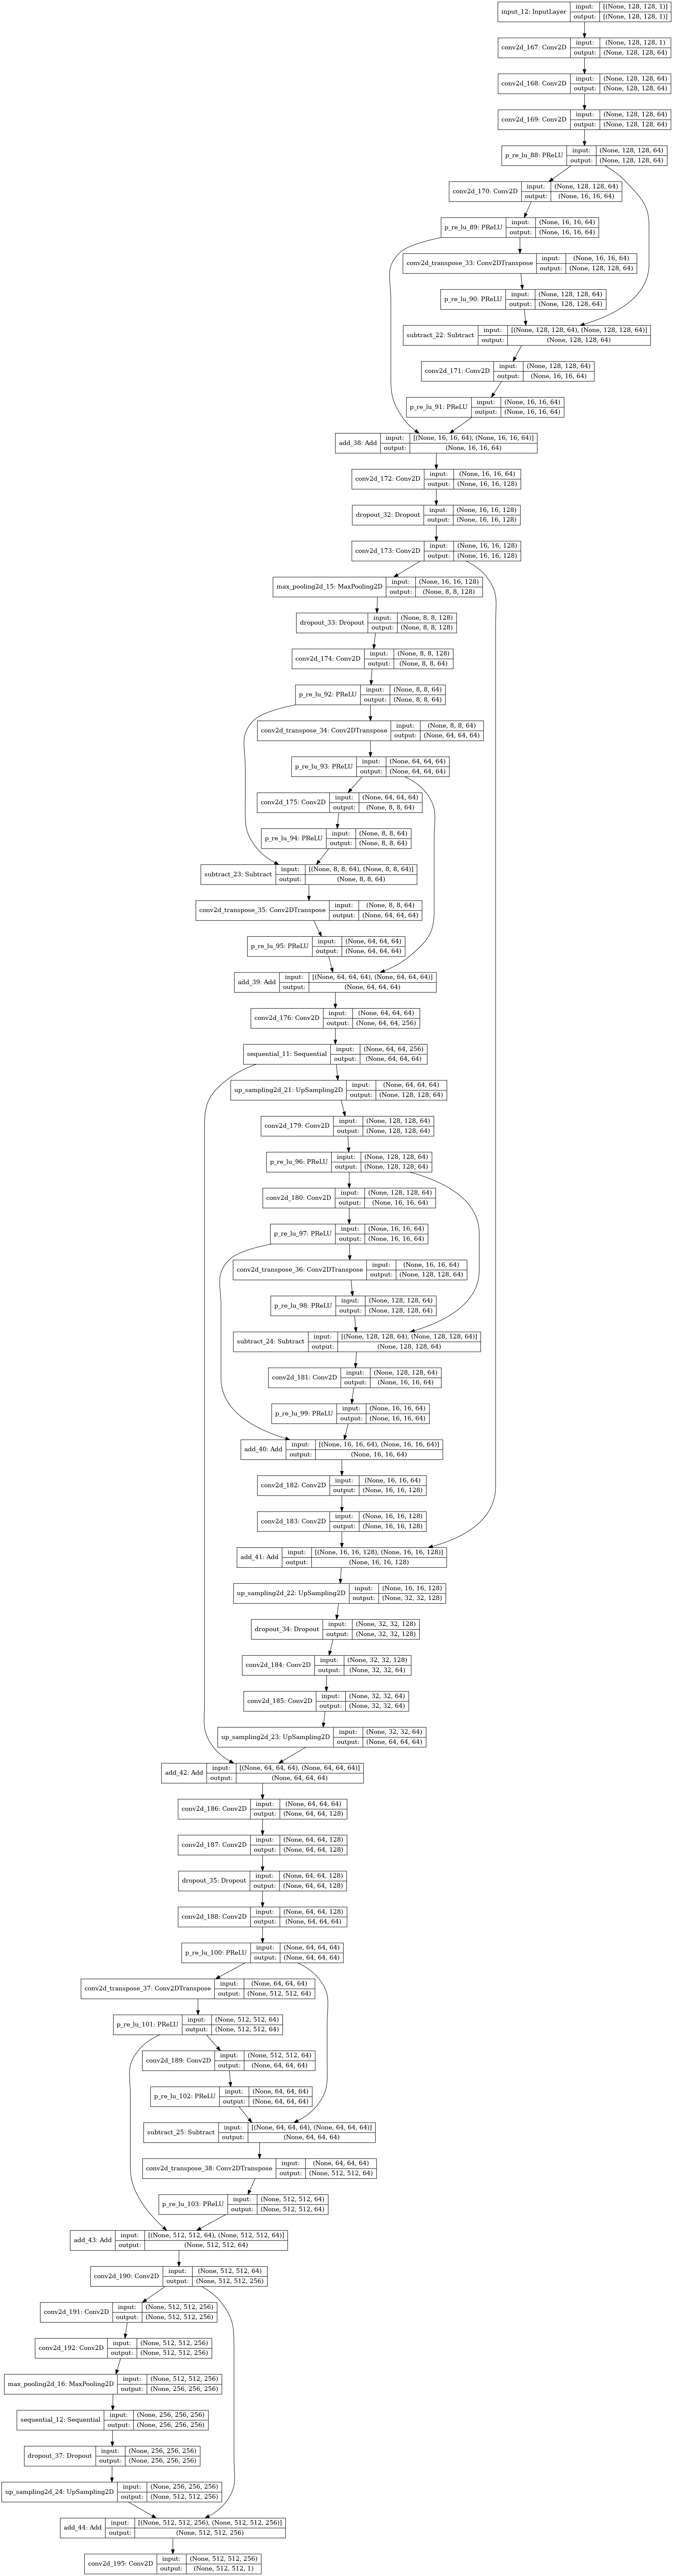

In [29]:
### for 4x

import os 
import re 
from scipy import ndimage, misc 
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import img_to_array


from skimage.transform import resize, rescale
import matplotlib.pyplot as plt
import numpy as np
np. random. seed(0)
import cv2 as cv2

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense ,Conv2D,MaxPooling2D ,Dropout
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
import tensorflow as tf

def wt_to_conv64(arr):
    return tf.tile(arr, [1,1,1,16])
def wt_to_conv128(arr):
    return tf.tile(arr, [1,1,1,32])

def residual_block_gen(ch=64,k_s=3,st=1):
    model=tf.keras.Sequential([
    tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),])
    return model

input_img=Input(shape=(128,128,1))
l1=Conv2D (64,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(input_img)
l2=Conv2D (64,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l1)
#l3=MaxPooling2D(padding='same')(l2)

l3 = DownBlocks(l2)

l5=Conv2D (128,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l3)
l5 = Dropout(0.50)(l5)
l6=Conv2D (128,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l5)
l7=MaxPooling2D(padding='same')(l6)
l7 = Dropout(0.50)(l7)

l7 = UpBlocks(l7)

l8=Conv2D (256,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l7)
l8_0=residual_block_gen()(l8)
l8_1=UpSampling2D()(l8_0)

l8_2 = DownBlocks(l8_1)


l9=Conv2D (128,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l8_2)
l10=Conv2D (128,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l9)
l11=add([l10,l6])
l12=UpSampling2D()(l11)
l12 = Dropout(0.50)(l12)
l13=Conv2D (64,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l12)
l15=Conv2D (64,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l13)

#l15=add([l14,l2])

l16=UpSampling2D()(l15)

l16=add([l16,l8_0])

l17 = Conv2D(128,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l16)
l18 = Conv2D(128,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l17)
l18 = Dropout(0.50)(l18)
#l19=UpSampling2D()(l18)

l18 = UpBlocks(l18)

l20 = Conv2D(256,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l18)
l21 = Conv2D(256,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l20)
l22 = Conv2D(256,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l21)
l23 = Dropout(0.50)(l22)
l23=MaxPooling2D(padding='same')(l22)
l24 = residual_block_gen(ch=256)(l23)
l24 = Dropout(0.50)(l24)
l25=UpSampling2D()(l24)
l26=add([l25,l20])


decoder=Conv2D (1,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l26)

#out= tf.keras.filters
autoencoder_residual=Model(input_img,decoder)
plot_model(autoencoder_residual, to_file ='encoder.png',show_shapes=True)